# A more accurate integrator for HMC
Hamiltonian Monte Carlo (HMC) (TODO: link) is a very popular MCMC sampling algorithm, which crucially depends on an integration scheme to approximate Hamiltonian's equations of motion.  
In this blog post, we will learn more about integration schemes and discuss two different integrators:
The first one is the classical leapfrog, which is the standard method to generate new proposal states for HMC. The second integration scheme is the $U_7$, which is more accurate, but also computationally more expensive.  

In this blog post, we will first remind you of the basic idea of HMC and then expose you to some classical menchanics.
With these foundations set, we formally describe the two integrators and then tentatively compare the performance of corresponding HMC implementations.
In case you are new to HMC or MCMC methods, a good starting point might be Tweag's [blog post series](https://www.tweag.io/blog/2019-10-25-mcmc-intro1/). 

# Introduction
Broadly speaking the idea of HMC is that given a previous state $x$ of our Markov chain, we draw a random momentum $v$ from a normal distribution and simulate the behaviour of a fictive particle with starting point $(x,v)$.
This intuition makes sense, because our probability density gives rise to a potential energy and vice versa (see, for example, [Tweag's HMC blog post](https://www.tweag.io/blog/2020-08-06-mcmc-intro3/)).
This deterministic behaviour is simulated for some fixed time $t$.
The final state $(x^\star, v^\star)$ of the particle after some time t will then serve as the new proposal state of a Metropolis-Hastings algorithm.

The motion of the fictive particle are governed by the Hamiltonian $$H(x,v) = K(v) + E(x).$$
Technically, the Hamiltonian does not necessarily need to be of the form "kinetic energy plus potential energy", meaning "separable", but it is in the most popular HMC implementations and it makes things a lot easier.
In fact, you can apply the splitting methods we discuss below to nonseparable Hamiltonians as well. 

As mentioned above, the key concept of the HMC method is to simulate the fictive particle's dynamics.
In terms of the Hamiltonian formalism, this is done by solving a set of differential equations, namely
$$
\frac{ 	\mathrm{d}x}{\mathrm{d}t} = \frac{\partial H }{\partial v}, \hspace{15pt} \frac{\mathrm{d}v}{\mathrm{d}t}= -\frac{\partial H }{\partial x}.
$$
The notation can be simplified by introducing $z=(x,v)$. Then the Hamiltonian equations of motion can be rewritten in a single expression as 
$$
\dot{z} = \begin{pmatrix}\dot x \\ \dot v\end{pmatrix} = \begin{pmatrix}\frac{\partial H }{\partial v} \\ -\frac{\partial H }{\partial x}\end{pmatrix} = \{z,H(z)\}
$$
where $\{\cdot, \cdot \}$ is the [Poisson bracket](https://en.wikipedia.org/wiki/Poisson_bracket).
The Poisson bracket is a differential operator of first order, which means that it uses first derivatives.
It essentially describes the change of any observable quantity with respect to the time evolution of a Hamiltonian system.
Furthermore, by introducing an operator $D_{H\cdot} = \{ \cdot, H \}$, the equation can be further simplified to 
$$
\dot z = D_H z
$$
and is formally solved by
$$
z(t) = \exp ( t D_H) z(0) = \exp ( t(D_K + D_E)) z(0).
$$ 
Note that $D_K$ and $D_E$ stand respectively for the operators $\{ \cdot, K \}$ and $\{ \cdot, E \}.$
The solution depends crucially on the potential energy, which in turn relates to the probability distribution of interest.
The latter in general is of non-standard form and the above solution to the Hamiltonian equations of motion can therefore not be obtained analytically. 

## A general recipe for symplectic integration: splitting methods
Because analytical solutions to the equations of motions are usually not available, we have to resort to numerical integration to get at least an approximate solution.
As discussed in a footnote of [Tweag's HMC blog post](https://www.tweag.io/blog/2020-08-06-mcmc-intro3/), we can't just use any integratoin scheme in HMC, but we should rather make sure it maintains [*symplecticity*](https://en.wikipedia.org/wiki/Symplectic_integrator#A_fourth-order_example), a crucial property of Hamilton's equations of motion.
A very general idea way of deriving symplectic integrator of arbitrary order are splitting methods, which we are presenting now.

In 1995 [Suzuki](http://people.ucalgary.ca/~dfeder/535/suzuki.pdf) proposed a new way to approximate expressions such as the solution of the Hamiltonian equations,
$$
\exp ( t(D_K + D_E)) = \prod_{i=1}^{k/2} \exp (c_i t D_K) \exp (d_i t D_E) + \cal{O}(t^{k+1}),
$$
where $\Sigma_{i=1}^k c_i = \Sigma_{i=1}^k d_i =1.$ You can think of this formula as a generalization of the identity $e^{m+n} = e ^m \cdot e^n.$ The error term is a result of the fact that operators (here represented as matrices) generally do not commute. 

Each of the factors $\exp (c_i t D_K)$ will correspond to an update of the state $x$ and similarly $\exp (d_i t D_E)$ can be translated to an update of the momentum $v.$ [^1]

Now, that we know how to come up with an approximation of the solution of the Hamiltonian equations, lets give a first example of one approximative algorithm:

## The Leapfrog

<!-- 
For now, let's come back to our fictive particle. As so often the differential eqaution is actually not always analytically tractable and so we need a way to approximate the behaviour of our fictive particle. And this is where the leapfrog method comes into play. 
--> 
The intuition behind the Leapfrog algorithm is that we update the space coordinate $x$ half a time step apart from the momentum variable $v$ one after the other multiple times. This behaviour has given the *Leapfrog* algorithm its name. **TODO:** name source for this image

![](Leapfrog.gif)

More rigorously, the updates look like the following,
$$
x_{i+1}= x_n +   v_{i + 1/2} \Delta t
$$
$$
v_{i + 3/2} = v_{i+1/2} + \left(-\frac{\partial}{\partial x} E(x_{i+1})\right) \Delta t
$$

As you might have noticed, you need to perform half a step for the momentum in the beginning and in the end. 
So, in terms of Suzuki, the Leapfrog looks like this
$$
\text{Leapfrog} =  U_3 U_3 \cdots U_3, 
$$
where 
$$
U_3 = \exp \left(\frac {1}{2}\Delta t D_E\right)\exp (\Delta t D_K)\exp \left(\frac {1}{2}\Delta t D_E\right).
$$
The coefficients are $c_1 = 0,\, c_2 = 1,\, d_1=d_2 = \frac{1}{2}.$

If we further divide our time $t$ into $t =  \text{time_step} \cdot   \text{trajectory_length}$ and apply the Suzuki approximation $U_3$ $\text{trajectory_length}$-many times, then a small function, approximating the desired behaviour for some time $t$, would have the following form:

In [1]:
def integrate(x, v):

    v += 1./2 * time_step * -gradient_pot_energy(x)

    for i in range(trajectory_length-1):
        x += time_step * v
        v += time_step * gradient_pot_energy(x)

    x += time_step * v
    v += 1./2 * time_step * gradient_pot_energy(x)

    return x, v

An important concept when talking about accuracy of integration schemes is that of the *order* of an integrator:
say $(x^\star,v^\star)$ is the exact solution after time $t$ and $(x_{t},v_{t})$ an approximation, then we say that the approximation is of *n*th-order and write $\mathcal{O}(t^n)$, if $\Vert(x^\star,v^\star)-(x_{t},v_{t}) \Vert\leq C \cdot t^n$ and $C$ is independent of $t$.

One can easily verify by simple calculation (**TODO:** make a footnote quickly sketching how this works) that the $U_3$ is exact to first-order in $\Delta t$. Because of the symmetry, the error terms need to be of odd-order.[^2]  Thus (**TODO:** thus means that what comes now follows from the previous sentence, but this is not true. Order 1 is an odd order, so this is no reason that leapfrog should be second order) the $U_3$ is also correct up to $\Delta t ^2$ and ideed, the leading error is of third-order. In this sense, the $U_3$ is a second-order approximation and the Leapfrog too. **TODO:** here it sounds likle leapfrog and $U_3$ are two different things? 

Now you might wonder: why look further since we have found a method yielding a reasonably exact approximation?
After all, we can always diminish the error by shortening the time step and increasing the trajectory length!

Well, one answer is that there might be a more efficient way to approximate the equations of motions.
But it also turns out that the Leapfrog is already not exact even for situations with a constant force $\vec F = -\nabla E = \text{const}$.
This is exactly why, originally, a five-factor approximation was considered by [Chau et al.](https://iopscience.iop.org/article/10.1088/1367-2630/aacde1/pdf).
Unfortunately, this approximation has still error terms of third order.
And to get rid of those, they propose the...

## The $U_7$
The novelty of the $U_7$ consists of the usage of the second-order derivative of the potential energy. This comes along with a few more updates of $x$ and $v$ per step and yields a lower error. 

The $U_7$ approximation was first discovered by [Chin (1997)](https://www.sciencedirect.com/science/article/abs/pii/S0375960197000030), but later independently obtained through an entirely different approach in [Chau et al.](https://iopscience.iop.org/article/10.1088/1367-2630/aacde1).

Concretely, the $U_7$, as the name suggests, is in the work of Chau *et al.* a seven-factor approximation.
The use of a special [trick](https://en.wikipedia.org/wiki/Baker%E2%80%93Campbell%E2%80%93Hausdorff_formula) makes it possible to reduce three factors to one, making it a five-factor approximation.[^3]
Because the Chau *et al.* paper is focused on quantum mechanical applications, we want to sketch a more intuitive way of deriving the U7.

When we want to apply $e ^A \cdot e^B \cdot e^C= e^{A+B+C}$ to operators, we remember that we must take into account that they do not commute.
This identity thus does not hold in the general case, but we can use a series expansion, which, similar to a Taylor expansion, involves higher order derivatives. This is the approach taken in Chin's paper.
Then, cutting off the expansion leaves us with an additional error, but even though we were able to reduce the number of factors, the approximation contains an error of order $\cal{O}(t^5)$.
Consequently, the $U_7$ remains exact up to fourth order and is therefore said to be a fourth-order approximation.

Either way, the newly formed term involes the second order derivative and the final $U_7$ factorization is given by

$$U_7 = \exp \left(\frac {1}{6}t D_E\right)\exp \left(\frac {1}{2}t D_K\right)\exp \left(\frac {2}{3}t D_\tilde{V}\right)\exp \left( \frac {1}{2}t D_K\right)\exp \left(\frac {1}{6}t D_E\right),$$

whereas $D_\tilde V = \{\cdot , V + \frac{1}{48}[t\nabla V ]^2\}.$ 

A Python implementation of the algorithm described above would look like this:

In [ ]:
def integrate(x, v):

    v += 1./6 * time_step * gradient_pot_energy(x)

    for i in range(trajectory_length-1):
        x += 1./2 * v * time_step
        v += (2./3 * time_step * (gradient_pot_energy(x)
            + time_step**2./24
            * np.matmul(hessian_log_prog(x),gradient_pot_energy(x))))
        x += 1./2 * v * time_step
        v += 1./3 * time_step * gradient_pot_energy(x)

    x += 1./2 * v * time_step
    v += (2./3 * time_step * (gradient_pot_energy(x)
        + time_step**2./24
        * np.matmul(hessian_log_prog(x),gradient_pot_energy(x))))
    x += 1./2 * v * time_step
    v += 1./6 * time_step * gradient_pot_energy(x)

    return x, v

Bear in mind that the higher accuracy achieved with $U_7$ comes with a non-negligible additional computational cost, namely evalutating the gradient two times instead of one time and additionally evaluating the matrix of second derivatives. 

## Benchmarking leapfrog and $U_7$-based HMC
In [this paper](https://arxiv.org/abs/2007.05308), Jun Hao Hue *et al.* benchmark the performance of the leapfrog and $U_7$ against various classical and quantum systems, but are not concerned with their use in HMC.

To compare the performance of the leapfrog and U7 integration schemes in the context of HMC, we plug above implementations into HMC and sample from two different probability distributions.

The first example is a 100-dimensional standard normal distribution.
Because of the high symmetry of this distribution, we have to be careful to not compare apples and oranges:
if we integrate for different total times, the trajectory might double back and we would waste computational effort (**TODO**: link or explanation).
We thus fix the total integration time (given by `number of integration steps x time step`) to ten time units and run HMC for different combinations of time step and number of integration steps.
If we can use a higher time step, we have to perform less integration steps, which means less costly gradient and Hessian evaluations.

![title](Figure_2.png)

We find indeed that the acceptance rate stays almost constant at almost one for a wide range of time steps, while the HMC implementation based on the leapfrog integration scheme shows rapidly diminishing acceptance rates.
This confirms that we have implemented the U7 integrator correctly and makes us even more excited to test it on a "real" system!

As a more practical application, we consider a simple, coarse-grained polymer model of a biomolecule, for example, a protein or DNA.
In biomolecular structure determination, one seeks to infer the coordinates of atoms or coarse-grained modeling units (*monomers*) of a polymer model from data obtained from biophysical experiments.
Often, this data comes in the form of distances between monomers.
In Inferential Structure Determination (ISD, [Rieping et al. (2005)](https://science.sciencemag.org/content/309/5732/303.long)), structure determination is viewed as a problem in Bayesian inference:
given the prior information $I$ in the form of a coarse-grained polymer model and data $D$ from experiments, what do we know about the coordinates $x$ of the underlying biomolecular structure?
The answer is given by the posterior distribution
$$
p(x|D,I) \propto p(D|x, I) \times p(x|I),
$$
which is intractable and sampling from which can thus only be achieved using MCMC methods.  

In our case, we consider a polymer of $N=30$ spherical particles of radius $r$.
The distances between neighboring particles are distributed normally and there is a "volume exclusion" force that makes sure particles do not overlap much.
We furthermore have "measured" a distance $2r$ between the first and the 6th and the first and the 26th monomer and assume the likelihood is given by a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).  
This setup results in a non-tractable posterior distribution over $N \times 3=90$ parameters, from which we sample using HMC with either the leapfrog or the $U_7$ integrator.  
Drawing 10000 samples with a trajectory length of ten steps and varying time steps, we find the following results for the [effective sample size (ESS)](https://mc-stan.org/docs/2_19/reference-manual/effective-sample-size-section.html) of the log-posterior probability and the acceptance rate:

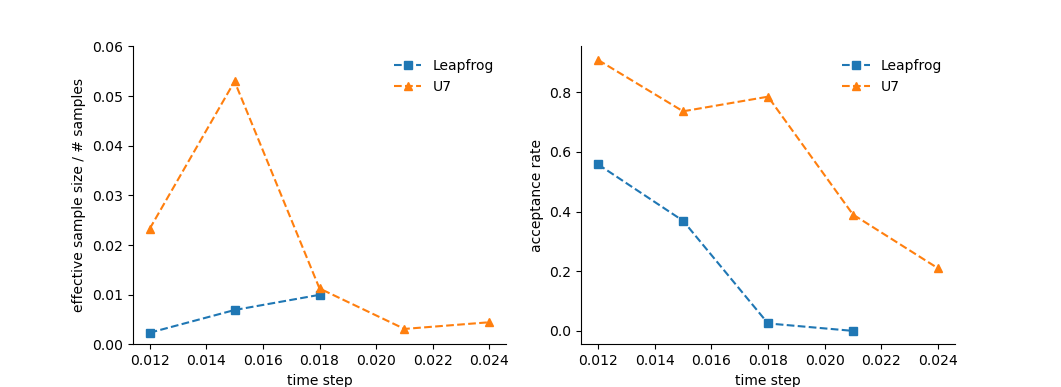

We find that, just as for the 100-dimensional normal distribution, the $U_7$ HMC shows significantly increased acceptance rates as compared to the leapfrog HMC.
The calculation of the ESS shows that for the two smallest time steps tested, the estimated number of independent samples is much higher for the $U_7$-based HMC than for the standard implementation.
It is also important to note that if the acceptance rate is very low, the ESS tends to get vastly overestimated (**TODO:** remember reference), which means that also for the third time step, the ESS obtained with standard HMC is probably somewhat lower than for the implementation with the more accurate integrator.  

What does this mean w.r.t. to absolute performance? Remember that while the $U_7$ yields better acceptance rates and higher ESS, it also requires more computing time.
We can estimate this additional computing time by assuming that the most expensive part during numerical integration is the evaluation of the square root in the distance calculations.
Because of the volume exclusion term, each pairwise distance needs to get evaluated.
This happens one time in a leapfrog iteration, but two times during an $U_7$ iteration, because the gradient / second derivatives are evaluated at two different points in time instead of only one.
We can thus estimate that the computational effort for a $U_7$ iteration is approximately twice the effort for a leapfrog iteration, although there surely is some additional, implementation-specific overhead.
Given that, based on the ESS estimation, we can achieve much more than twice the number of independent samples with $U_7$, we can conclude that the $U_7$ integrator indeed is a very promising way to boost HMC performance.

## Footnotes
1. This algorithm in operator notation has quite a simple representation in canonical coordinates. Since one can show that $D_K^2 z = (0,0)$, the taylor expansion of $\exp (a D_K) $ reduces to $\Sigma_{n=0}^{\infty} \frac{(a D_K)^n}{n!} = 1+ aD_K$. This in turn makes $\exp(\beta_i \Delta t D_K)$ the mapping 
$$
\begin{pmatrix}x \\v\end{pmatrix} \mapsto \begin{pmatrix}x +  \Delta t \beta_i \frac{\partial K}{\partial v} (v)\\v\end{pmatrix}
$$
and $\exp(\beta_i\Delta  t D_E)$ gives 
$$
\begin{pmatrix}x \\v\end{pmatrix} \mapsto \begin{pmatrix}x \\v - \Delta t \beta_i \frac{\partial E}{\partial x} (x)\end{pmatrix}.
$$ 
2. One interesting remark is that, for symmetric approximations, $U(t)U(-t) = 1$, the error terms cannot be of even order since then, intuitively speaking, the error would point in the same direction, because $t^{2n} = (-t)^{2n}$. **TODO:** clarify this foot note. What is $U(t)$? Perhaps add that the error cancels out in $U(-t)U(t)$.
3. Here's how the second derivative comes into play. The Baker-Campbell-Hausdorff formula is a representation of solution $Z$ to the equation $e^Xe^Y=e^Z$ in terms of a series. The first terms of this series are: 
$$
Z = X+Y + \frac{1}{2}[X,Y]+\frac{1}{12}[X,[X,Y]]-\frac{1}{12}[Y,[X,Y]]+\cdots,
$$ 
where "$\cdots$" indicates terms involving higher commutators. Remember now that the operators in our case involve the Poisson bracket, which is a differential operator. Then, nesting the Poisson bracket implies the usage of higher (in our case, second) order derivatives.

<!--
#### But wait!

I dont want to loose any of you right on the spot, just because I used the term differential equation. It is actually much simpler than that, so don't worry. Just let me show you one simple remarkable result.

In our case of the seperable Hamiltonian, we can rewrite the differential equations, by just using the terms, that are actually dependend on the variable, we want to take the derivativ of, so
$$\frac{dx}{dt} = \frac{\partial}{\partial v} K(v) = \frac{v}{m}, \hspace{15pt} \frac{dv}{dt}= -\frac{\partial}{\partial x} E(x).$$

This might look already much more familiar to you. Just multiply the left equation with m and take once more the derivate with respect to $t$ gives us $m\frac{d^2x}{dt^2}  = \frac{dv}{dt}.$ This then plugt into the second equation 
$$m\frac{d^2x}{dt^2}  = \frac{dv}{dt} = -\frac{\partial}{\partial x} E(x) = F$$
leaves us with Newton's beautiful second law of motion.

-->